## Data visualisation


In [42]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA



import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline


# Spectrogramme:


In [43]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

train_audio_path = 'train/audio/'
filename = '/happy/0bde966a_nohash_1.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

Text(0.5,0,'Seconds')

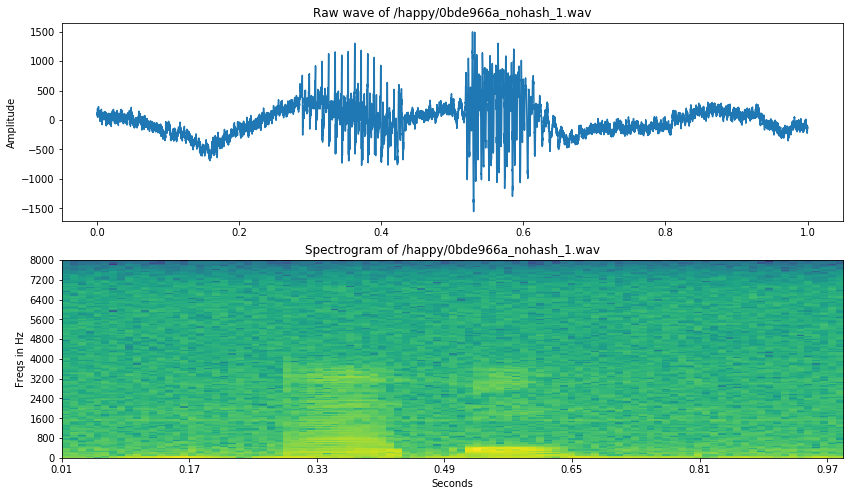

In [44]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [13]:
data = [go.Surface(z=spectrogram.T)]
layout = go.Layout(
    title='Specgtrogram of "yes" in 3d',
    scene = dict(
    yaxis = dict(title='Frequencies', range=freqs),
    xaxis = dict(title='Time', range=times),
    zaxis = dict(title='Log amplitude'),
    ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# Enlever le silence


In [77]:
samples_cut = samples[4000:13000]


# Réduction de dimensions



In [49]:
def calcul_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [50]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

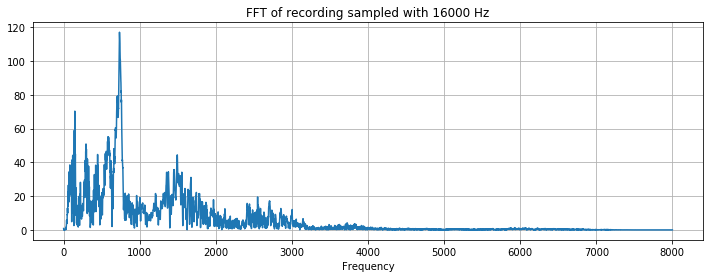

In [53]:
xf, vals = calcul_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

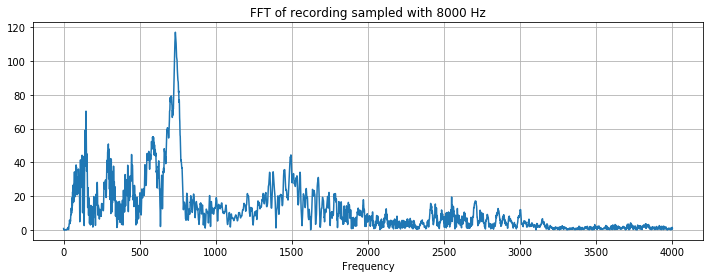

In [54]:
xf, vals = calcul_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()



# Nombre d'exemples



In [67]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Nombre de classes: ' + str(len(dirs)))

Nombre de classes: 31


In [68]:
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='Viridius', showscale=True
    ),
)
layout = go.Layout(
    title='Nombre d exemples dans la classe correspondante',
    xaxis = dict(title='Mots'),
    yaxis = dict(title='Nombre d exemples')
)
py.iplot(go.Figure(data=[trace], layout=layout))


# Taille des enregistrements



In [69]:

def less_onesecond_record():
    num_of_shorter = 0
    for direct in dirs:
        waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
        for wav in waves:
            sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
            if samples.shape[0] < sample_rate:
                num_of_shorter += 1
    return num_of_shorter

print(less_onesecond_record())

/home/eleonore/.local/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



6469


# 2 Moyenne des FFT et des spectro


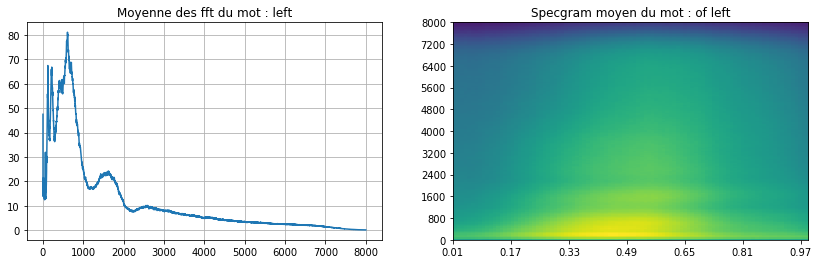

([array([[ -7.028711 ,  -4.100849 ,  -1.3353435, ..., -10.524568 ,
        -11.509426 , -11.682385 ],
       [ -8.422186 ,  -3.4027348,  -1.4832762, ..., -12.819554 ,
        -11.573272 , -11.221349 ],
       [ -8.734534 ,  -8.858963 ,  -3.1287775, ..., -11.835367 ,
        -12.421505 , -15.242285 ],
       ...,
       [ -6.2303224,  -4.2891493,  -1.1295177, ..., -11.717378 ,
        -12.98773  , -13.395473 ],
       [ -8.593007 ,  -2.529397 ,  -1.0859593, ..., -12.291646 ,
        -11.916    , -11.522849 ],
       [ -7.2415595,  -4.6207952,  -1.3197136, ..., -13.449334 ,
        -10.759675 , -13.628617 ]], dtype=float32), array([[ -9.351672  ,  -4.4135885 ,  -2.640999  , ...,  -7.7750626 ,
         -9.112071  , -14.037456  ],
       [ -8.739101  ,  -4.6485076 ,  -2.4081702 , ...,  -8.98156   ,
        -11.5793    , -10.240101  ],
       [ -6.8820558 ,  -4.090961  ,  -1.9406781 , ...,  -7.2527065 ,
         -8.262649  , -10.422949  ],
       ...,
       [ -1.7838025 ,  -0.98877203,  -1

In [71]:


def mean_fft():
    dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
    to_keep = 'yes no up down left right on off stop go'.split()
    dirs = [d for d in dirs if d in to_keep]
    for direct in dirs:
        vals_all = []
        spec_all = []

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
        for wav in waves:
            sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
            if samples.shape[0] != 16000:
                continue
            xf, vals = custom_fft(samples, 16000)
            vals_all.append(vals)
            freqs, times, spec = log_specgram(samples, 16000)
            spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Moyenne des fft du mot : ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Specgram moyen du mot : of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()
    
    return spec_all, vals_all

print(mean_fft())

# Fréquence dans chaque classe de mots



In [75]:
def word_frequency(dirs, freq_ind):
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    return spec_all
spec_all = word_frequency(dirs, 20)

/home/eleonore/.local/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



# Détection des outliers


In [76]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names)

/home/eleonore/.local/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.



ValueError: negative dimensions are not allowed